In [31]:
import tensorflow as tf
from tensorflow.python.keras import models as m
from tensorflow.python.keras import layers as l

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import confusion_matrix, fbeta_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix

import seaborn as sn
import pandas as pd

import ROOT as rt

import os
import sys
sys.path.insert(0, os.path.abspath('/home/arsahasransu/Documents/SoftDisplacedLeptons/Classifier/'))

print("All classes initialized successfully!!!")

All classes initialized successfully!!!


In [2]:
import plotBeautifier as pB
import DrawROC as dR

In [3]:
pB.trial_func("AR")

Trial works fine. Hello,AR


In [4]:
sigChan = rt.TChain("varTree")
sigChan.Add("signal.root")
sigChan_BP100200 = rt.TChain("varTree")
sigChan_BP100200.Add("signal_BP_100_200.root")
bkgChan = rt.TChain("varTree")
bkgChan.Add("background.root")
print("Data read from the trees. Printing out the contents.")

Data read from the trees. Printing out the contents.


In [5]:
brNameList = []
for br in sigChan.GetListOfBranches():
    brNameList.append(br.GetName())
    
print(brNameList)
print(len(brNameList))

['HtJet', 'dRLL', 'dPhiLepMETSelObj', 'YDelpObj', 'YUserObj', 'alphaT', 'Sphericity', 'Spherocity', 'MtLeadLepMET']
9


In [6]:
# Read input data from root files
sigSampleSize = sigChan.GetEntries()
sigSampleSize_BP100200 = sigChan_BP100200.GetEntries()
bkgSampleSize = bkgChan.GetEntries()

# Convert the input data to matrices
sigFull = sigChan.AsMatrix()
sigFull_BP100200 = sigChan_BP100200.AsMatrix()
bkgFull = bkgChan.AsMatrix()

print(sigFull.shape)
print(sigFull_BP100200.shape)
print(bkgFull.shape)

(44440, 9)
(228099, 9)
(4108, 9)


In [7]:
# Load the input data scaler
scaler = joblib.load("../scaler.save")

# Load the model
loaded_model = m.load_model("../simplePer.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                180       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 38        
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


2020-03-23 11:46:10.119705: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


In [8]:
# Predict on the samples

sigFullScaled = scaler.transform(sigFull)
sigFullScaled_BP100200 = scaler.transform(sigFull_BP100200)
bkgFullScaled = scaler.transform(bkgFull)

sigFullPredict = loaded_model.predict(sigFullScaled)
sigFullPredict_BP100200 = loaded_model.predict(sigFullScaled_BP100200)
bkgFullPredict = loaded_model.predict(bkgFullScaled)

print(sigFullScaled.shape)
print(sigFullScaled_BP100200.shape)
print(bkgFullScaled.shape)

(44440, 9)
(228099, 9)
(4108, 9)


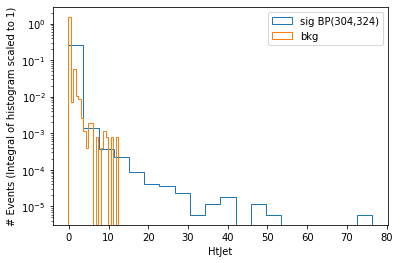

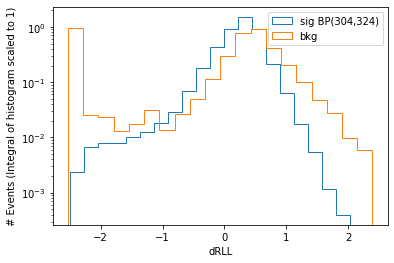

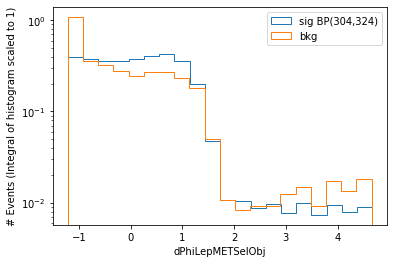

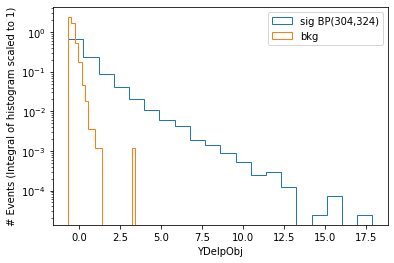

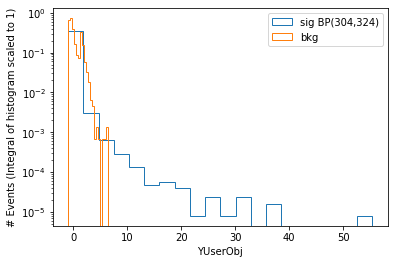

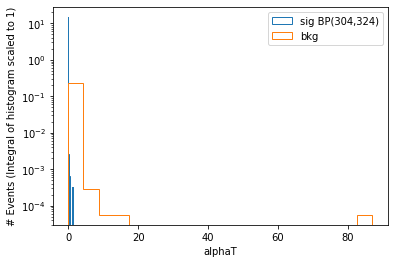

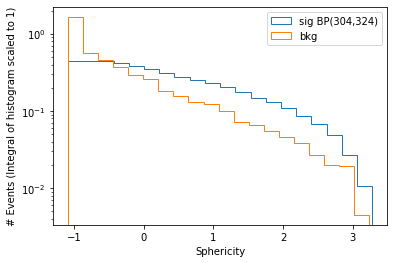

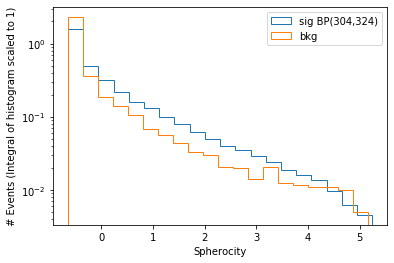

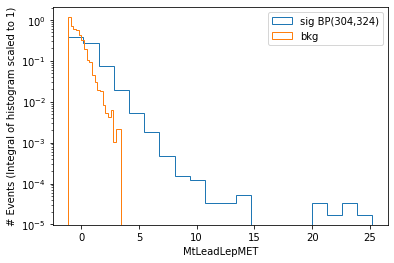

In [187]:
for i in np.arange(0,9,1):
    plt.clf()
    plt.yscale('log')
    #plt.xscale('log')
    #plt.hist(np.array(np.transpose(sigFull)[i]), bins=20, density=True, color=None, histtype='step', label='sig BP(304,324) Unscaled')
    #plt.hist(np.array(np.transpose(bkgFull)[i]), bins=20, density=True, color=None, histtype='step', label='bkg Unscaled')
    plt.hist(np.array(np.transpose(sigFullScaled)[i]), bins=20, density=True, color=None, histtype='step', label='sig BP(304,324)')
    plt.hist(np.array(np.transpose(bkgFullScaled)[i]), bins=20, density=True, color=None, histtype='step', label='bkg')
    plt.ylabel("# Events (Integral of histogram scaled to 1)")
    plt.xlabel(brNameList[i])
    plt.legend()
    plt.show()
    #plt.savefig(brNameList[i]+"_scaled.pdf")
    

In [10]:
# Make the pdf for signal probability

minXList = [20, 0, 0, 0, 0, 0.1, 0, 0, 0]
maxXList = [100, 5, 3.14, 10, 15, 1.5, 0.7, 0.6, 100]
nBinsX = [50, 30, 25, 50, 30, 40, 30, 30, 30]
sigProbList = []

histSigList = []
histBkgList = []

for (brName,minX,maxX,nBins) in zip(brNameList,minXList,maxXList,nBinsX):
    
    histSig = rt.TH1F(brName+"_Signal","",nBins,minX,maxX)
    histSig.Sumw2()
    histBkg = rt.TH1F(brName+"_Background","",nBins,minX,maxX)
    histBkg.Sumw2()
    
    sigChan.Draw(brName+">>"+histSig.GetName())
    histSig = rt.gDirectory.Get(histSig.GetName())
    bkgChan.Draw(brName+">>"+histBkg.GetName())
    histBkg = rt.gDirectory.Get(histBkg.GetName())
    histSig.GetXaxis().SetRange(0, histSig.GetNbinsX()+1)
    histBkg.GetXaxis().SetRange(0, histBkg.GetNbinsX()+1)
    histSig.Scale(1.0/histSig.Integral())
    histBkg.Scale(1.0/histBkg.Integral())
    histSigList.append(histSig)
    histBkgList.append(histBkg)
    
    c1 = rt.TCanvas()
    c1.SetLogy()
    histSig.Draw("hist")
    histBkg.SetLineColor(rt.kRed)
    histBkg.Draw("hist SAME")
    c1.SaveAs("VarPlot/"+brName+".pdf")
    del c1

    histBkg.Add(histSig) # Adds the histograms for denominator
    histSig.Divide(histBkg) # Stores the pdf for signal prob.
    sigProbList.append(histSig)
    
    c1 = rt.TCanvas()
    histSig.Draw("hist")
    c1.SaveAs("PdfSigProb/"+brName+".pdf")
    del c1

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Info in <TCanvas::Print>: pdf file VarPlot/HtJet.pdf has been created
Info in <TCanvas::Print>: pdf file PdfSigProb/HtJet.pdf has been created
Info in <TCanvas::Print>: pdf file VarPlot/dRLL.pdf has been created
Info in <TCanvas::Print>: pdf file PdfSigProb/dRLL.pdf has been created
Info in <TCanvas::Print>: pdf file VarPlot/dPhiLepMETSelObj.pdf has been created
Info in <TCanvas::Print>: pdf file PdfSigProb/dPhiLepMETSelObj.pdf has been created
Info in <TCanvas::Print>: pdf file VarPlot/YDelpObj.pdf has been created
Info in <TCanvas::Print>: pdf file PdfSigProb/YDelpObj.pdf has been created
Info in <TCanvas::Print>: pdf file VarPlot/YUserObj.pdf has been created
Info in <TCanvas::Print>: pdf file PdfSigProb/YUserObj.pdf has been created
Info in <TCanvas::Print>: pdf file VarPlot/alphaT.pdf has been created
Info in <TCanvas::Print>: pdf file PdfSigProb/alphaT.pdf has been created
Info in <TCanvas::Print>: pdf file V

In [188]:
# Use the pdf for signal probability to 
# calculate the linear likelihood discriminator

discrListSig = []
for event in sigFull:
    
    discr = 1.0
    psig = 1.0
    pbkg = 1.0
    for (var,sigHist,bkgHist) in zip(event,histSigList,histBkgList):
        binNum = sigHist.FindBin(var)
        psig *= sigHist.GetBinContent(binNum)
        binNum = bkgHist.FindBin(var)
        pbkg *= bkgHist.GetBinContent(binNum)
    
    discr = psig/(psig+pbkg)
    discrListSig.append(discr)

discrListBkg = []
for event in bkgFull:
    
    discr = 1.0
    psig = 1.0
    pbkg = 1.0
    for (var,sigHist,bkgHist) in zip(event,histSigList,histBkgList):
        binNum = sigHist.FindBin(var)
        psig *= sigHist.GetBinContent(binNum)
        binNum = bkgHist.FindBin(var)
        pbkg *= bkgHist.GetBinContent(binNum)
        
    discr = psig/(psig+pbkg)
    discrListBkg.append(discr)

print(len(discrListSig))
print(len(discrListBkg))

44440
4108


In [131]:
# LL on individual variable

varCtr = 3
discrListSig = []
for event in sigFull:
    
    discr = 1.0
    psig = 1.0
    pbkg = 1.0

    var = event[varCtr]
    sigHist = histSigList[varCtr]
    bkgHist = histBkgList[varCtr]
    
    binNum = sigHist.FindBin(var)
    psig *= sigHist.GetBinContent(binNum)
    binNum = bkgHist.FindBin(var)
    pbkg *= bkgHist.GetBinContent(binNum)
    
    discr = psig/(psig+pbkg)
    discrListSig.append(discr)

discrListBkg = []
for event in bkgFull:
    
    discr = 1.0
    psig = 1.0
    pbkg = 1.0

    var = event[varCtr]
    sigHist = histSigList[varCtr]
    bkgHist = histBkgList[varCtr]

    binNum = sigHist.FindBin(var)
    psig *= sigHist.GetBinContent(binNum)
    binNum = bkgHist.FindBin(var)
    pbkg *= bkgHist.GetBinContent(binNum)
        
    discr = psig/(psig+pbkg)
    discrListBkg.append(discr)

print(len(discrListSig))
print(len(discrListBkg))

44440
4108


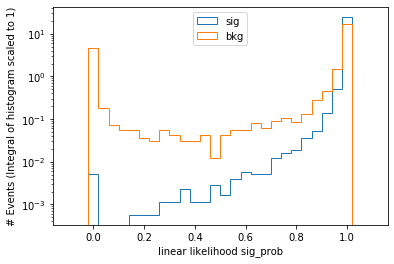

In [194]:
plt.clf()
plt.yscale('log')
#plt.xscale('log')
plt.hist(discrListSig, bins=30, range=(-0.1,1.1), density=True, color=None, histtype='step', label="sig")
plt.hist(discrListBkg, bins=30, range=(-0.1,1.1), density=True, color=None, histtype='step', label="bkg")
plt.legend(loc='upper center')
plt.ylabel("# Events (Integral of histogram scaled to 1)")
plt.xlabel("linear likelihood sig_prob")
plt.savefig("ll_disc.pdf")
plt.show()

In [195]:
# ROC for linear likelihood estimator

tprLL = []
fprLL = []

maxLL = max(discrListSig) if max(discrListSig)>max(discrListBkg) else max(discrListBkg)
nstep = 1000.0
startVal = 0
endVal = maxLL-maxLL*1.0/nstep
diffVal = maxLL*1.0/nstep

for i in range(5):
    
    LLdiscrStep = np.arange(startVal, endVal, diffVal)
    for LLdiscrCut in LLdiscrStep:
    
        tp = (discrListSig>LLdiscrCut).sum()
        fp = (discrListBkg>LLdiscrCut).sum()
        tn = (discrListBkg<LLdiscrCut).sum()
        fn = (discrListSig<LLdiscrCut).sum()
    
        tprLL.append(tp/(tp+fn))
        fprLL.append(fp/(fp+tn))
    
        print(LLdiscrCut,tp/(tp+fn),fp/(fp+tn))
        
    startVal = endVal
    diffVal = diffVal*1.0/nstep
    endVal = maxLL-diffVal

0.0 1.0 1.0
0.001 0.9998649864986499 0.8770691333982473
0.002 0.9998199819981998 0.8571080817916261
0.003 0.9998199819981998 0.8463972736124635
0.004 0.9997974797479748 0.8395813047711782
0.005 0.9997974797479748 0.8351996105160662
0.006 0.9997974797479748 0.8325219084712756
0.007 0.9997974797479748 0.8303310613437196
0.008 0.9997974797479748 0.8281402142161636
0.009000000000000001 0.9997974797479748 0.8264362220058422
0.01 0.9997974797479748 0.8249756572541382
0.011 0.9997974797479748 0.8237585199610516
0.012 0.9997974797479748 0.8227848101265823
0.013000000000000001 0.9997974797479748 0.8220545277507303
0.014 0.9997974797479748 0.8208373904576436
0.015 0.9997974797479748 0.8205939629990263
0.016 0.9997974797479748 0.818889970788705
0.017 0.9997974797479748 0.8181596884128529
0.018000000000000002 0.9997974797479748 0.8171859785783836
0.019 0.9997974797479748 0.8166991236611489
0.02 0.9997974797479748 0.8162122687439143
0.021 0.9997974797479748 0.8157254138266796
0.022 0.99979747974797

0.182 0.9997749774977498 0.8018500486854917
0.183 0.9997749774977498 0.8011197663096398
0.184 0.9997749774977498 0.8011197663096398
0.185 0.9997749774977498 0.8011197663096398
0.186 0.9997749774977498 0.8011197663096398
0.187 0.9997749774977498 0.8008763388510224
0.188 0.9997749774977498 0.8008763388510224
0.189 0.9997749774977498 0.8008763388510224
0.19 0.9997749774977498 0.8008763388510224
0.191 0.9997749774977498 0.8008763388510224
0.192 0.9997749774977498 0.8008763388510224
0.193 0.9997749774977498 0.8008763388510224
0.194 0.9997749774977498 0.8008763388510224
0.195 0.9997749774977498 0.8006329113924051
0.196 0.9997749774977498 0.8006329113924051
0.197 0.9997749774977498 0.8006329113924051
0.198 0.9997749774977498 0.8006329113924051
0.199 0.9997749774977498 0.8006329113924051
0.2 0.9997749774977498 0.8006329113924051
0.201 0.9997749774977498 0.8006329113924051
0.202 0.9997749774977498 0.8006329113924051
0.203 0.9997749774977498 0.8006329113924051
0.20400000000000001 0.9997749774977

0.376 0.9995499549954996 0.7940603700097371
0.377 0.9995499549954996 0.7940603700097371
0.378 0.9995499549954996 0.7940603700097371
0.379 0.9995499549954996 0.7940603700097371
0.38 0.9995499549954996 0.7940603700097371
0.381 0.9995499549954996 0.7940603700097371
0.382 0.9995499549954996 0.7940603700097371
0.383 0.9995499549954996 0.7940603700097371
0.384 0.9995499549954996 0.7940603700097371
0.385 0.9995499549954996 0.7940603700097371
0.386 0.9995499549954996 0.7940603700097371
0.387 0.9995499549954996 0.7938169425511198
0.388 0.9995499549954996 0.7935735150925024
0.389 0.9995499549954996 0.7935735150925024
0.39 0.9995499549954996 0.7935735150925024
0.391 0.9995499549954996 0.7933300876338851
0.392 0.9995499549954996 0.7933300876338851
0.393 0.9995499549954996 0.7933300876338851
0.394 0.9995499549954996 0.7933300876338851
0.395 0.9995499549954996 0.7933300876338851
0.396 0.9995049504950495 0.7933300876338851
0.397 0.9995049504950495 0.7933300876338851
0.398 0.9995049504950495 0.7933300

0.5700000000000001 0.9991899189918992 0.7877312560856865
0.5710000000000001 0.9991899189918992 0.7877312560856865
0.5720000000000001 0.9991899189918992 0.7872444011684518
0.5730000000000001 0.9991224122412241 0.7870009737098345
0.5740000000000001 0.9991224122412241 0.7867575462512172
0.5750000000000001 0.9991224122412241 0.7867575462512172
0.5760000000000001 0.9991224122412241 0.7867575462512172
0.577 0.9991224122412241 0.7867575462512172
0.578 0.9991224122412241 0.7867575462512172
0.579 0.9991224122412241 0.7867575462512172
0.58 0.9991224122412241 0.7867575462512172
0.581 0.9991224122412241 0.7867575462512172
0.582 0.9991224122412241 0.7867575462512172
0.583 0.9991224122412241 0.7865141187925998
0.584 0.9991224122412241 0.7862706913339824
0.585 0.9991224122412241 0.7857838364167478
0.586 0.9991224122412241 0.7857838364167478
0.587 0.9991224122412241 0.7857838364167478
0.588 0.9991224122412241 0.7857838364167478
0.589 0.9991224122412241 0.7857838364167478
0.59 0.9990999099909991 0.7857

0.753 0.9976822682268227 0.7740993184031159
0.754 0.9976822682268227 0.7738558909444986
0.755 0.9976822682268227 0.7738558909444986
0.756 0.9976597659765977 0.7736124634858812
0.757 0.9976597659765977 0.7736124634858812
0.758 0.9976372637263726 0.7736124634858812
0.759 0.9976372637263726 0.7731256085686465
0.76 0.9976372637263726 0.7731256085686465
0.761 0.9976147614761476 0.7731256085686465
0.762 0.9976147614761476 0.7731256085686465
0.763 0.9975922592259225 0.7731256085686465
0.764 0.9975922592259225 0.7728821811100293
0.765 0.9975922592259225 0.7723953261927945
0.766 0.9975922592259225 0.7723953261927945
0.767 0.9975922592259225 0.7721518987341772
0.768 0.9975472547254726 0.7721518987341772
0.769 0.9975472547254726 0.7721518987341772
0.77 0.9975472547254726 0.7719084712755598
0.771 0.9975247524752475 0.7719084712755598
0.772 0.9974797479747974 0.7719084712755598
0.773 0.9974797479747974 0.7716650438169426
0.774 0.9974797479747974 0.7716650438169426
0.775 0.9974572457245725 0.7716650

0.9380000000000001 0.9881188118811881 0.7346640701071081
0.9390000000000001 0.9877587758775878 0.7341772151898734
0.9400000000000001 0.9875787578757875 0.7327166504381695
0.9410000000000001 0.9871962196219622 0.7319863680623174
0.9420000000000001 0.986993699369937 0.7314995131450828
0.9430000000000001 0.9868361836183618 0.7312560856864654
0.9440000000000001 0.9865886588658865 0.7300389483933788
0.9450000000000001 0.9862286228622862 0.7293086660175268
0.9460000000000001 0.9859135913591359 0.7280915287244402
0.9470000000000001 0.9856435643564356 0.7271178188899707
0.9480000000000001 0.9854185418541854 0.7266309639727361
0.9490000000000001 0.9853060306030603 0.7259006815968841
0.9500000000000001 0.985103510351035 0.7251703992210321
0.9510000000000001 0.9847434743474347 0.7239532619279455
0.9520000000000001 0.9844734473447345 0.7224926971762414
0.9530000000000001 0.9841584158415841 0.7215189873417721
0.9540000000000001 0.9837083708370837 0.7198149951314509
0.9550000000000001 0.983258325832

0.9990960000000028 0.7972322232223222 0.3933787731256086
0.9990970000000028 0.7971647164716472 0.3933787731256086
0.9990980000000028 0.7971197119711971 0.3928919182083739
0.9990990000000028 0.797007200720072 0.3928919182083739
0.9991000000000029 0.7968946894689469 0.39264849074975655
0.9991010000000029 0.7966921692169217 0.39264849074975655
0.9991020000000029 0.7965796579657966 0.39264849074975655
0.999103000000003 0.7965571557155715 0.3924050632911392
0.999104000000003 0.7964221422142215 0.3924050632911392
0.999105000000003 0.7963321332133213 0.3924050632911392
0.999106000000003 0.7962646264626463 0.3924050632911392
0.9991070000000031 0.7961746174617462 0.3924050632911392
0.9991080000000031 0.796062106210621 0.3924050632911392
0.9991090000000031 0.795972097209721 0.3924050632911392
0.9991100000000032 0.7958370837083708 0.3924050632911392
0.9991110000000032 0.7957020702070207 0.3924050632911392
0.9991120000000032 0.7956120612061206 0.3924050632911392
0.9991130000000032 0.79554455445544

0.9992460000000071 0.7826507650765077 0.37877312560856863
0.9992470000000071 0.7826057605760576 0.3785296981499513
0.9992480000000071 0.7825157515751575 0.37828627069133397
0.9992490000000072 0.7823582358235823 0.37804284323271664
0.9992500000000072 0.7821782178217822 0.377555988315482
0.9992510000000072 0.7820432043204321 0.37731256085686465
0.9992520000000072 0.7819756975697569 0.37731256085686465
0.9992530000000073 0.7818181818181819 0.3770691333982473
0.9992540000000073 0.7816831683168317 0.3770691333982473
0.9992550000000073 0.7815481548154816 0.3770691333982473
0.9992560000000074 0.7814806480648064 0.3770691333982473
0.9992570000000074 0.7813456345634563 0.3770691333982473
0.9992580000000074 0.7812556255625562 0.37682570593963
0.9992590000000074 0.7812556255625562 0.37682570593963
0.9992600000000075 0.7811881188118812 0.37633885102239534
0.9992610000000075 0.781098109810981 0.37633885102239534
0.9992620000000075 0.781030603060306 0.37633885102239534
0.9992630000000076 0.780963096

0.9994040000000116 0.7625562556255625 0.3612463485881207
0.9994050000000116 0.7623762376237624 0.3612463485881207
0.9994060000000117 0.7623087308730873 0.3612463485881207
0.9994070000000117 0.762083708370837 0.3612463485881207
0.9994080000000117 0.7619486948694869 0.3612463485881207
0.9994090000000118 0.7618136813681368 0.36075949367088606
0.9994100000000118 0.7616111611161116 0.3605160662122687
0.9994110000000118 0.7614761476147615 0.3602726387536514
0.9994120000000118 0.7613636363636364 0.36002921129503407
0.9994130000000119 0.7611611161116112 0.36002921129503407
0.9994140000000119 0.761003600360036 0.35978578383641674
0.9994150000000119 0.7608460846084608 0.35978578383641674
0.999416000000012 0.7607110711071107 0.35978578383641674
0.999417000000012 0.7605760576057605 0.35978578383641674
0.999418000000012 0.7603735373537354 0.35978578383641674
0.999419000000012 0.7603060306030603 0.3592989289191821
0.9994200000000121 0.7601710171017102 0.3592989289191821
0.9994210000000121 0.76003600

0.9995590000000161 0.736003600360036 0.33714703018500486
0.9995600000000161 0.7358235823582359 0.33690360272638753
0.9995610000000161 0.7354860486048604 0.33690360272638753
0.9995620000000162 0.7351710171017102 0.33641674780915287
0.9995630000000162 0.73499099909991 0.33617332035053554
0.9995640000000162 0.7349009900990099 0.3359298928919182
0.9995650000000162 0.7347209720972098 0.3356864654333009
0.9995660000000163 0.7344959495949595 0.3356864654333009
0.9995670000000163 0.7342034203420342 0.33471275559883157
0.9995680000000163 0.7340684068406841 0.33446932814021424
0.9995690000000164 0.733955895589559 0.3342259006815969
0.9995700000000164 0.7337983798379838 0.3339824732229795
0.9995710000000164 0.7335958595859586 0.3337390457643622
0.9995720000000164 0.7335508550855085 0.33349561830574487
0.9995730000000165 0.7333033303330333 0.33349561830574487
0.9995740000000165 0.733033303330333 0.33325219084712754
0.9995750000000165 0.7327632763276327 0.33325219084712754
0.9995760000000166 0.7326

0.9997130000000205 0.6974122412241224 0.3018500486854917
0.9997140000000205 0.6971422142214222 0.3018500486854917
0.9997150000000206 0.6969396939693969 0.3018500486854917
0.9997160000000206 0.6965571557155715 0.3018500486854917
0.9997170000000206 0.6962421242124213 0.3018500486854917
0.9997180000000206 0.695994599459946 0.30160662122687437
0.9997190000000207 0.6955670567056705 0.30160662122687437
0.9997200000000207 0.6951845184518451 0.30160662122687437
0.9997210000000207 0.6949369936993699 0.30136319376825704
0.9997220000000208 0.6944644464446444 0.30136319376825704
0.9997230000000208 0.6941044104410441 0.3008763388510224
0.9997240000000208 0.6938118811881188 0.30063291139240506
0.9997250000000208 0.6934518451845184 0.30063291139240506
0.9997260000000209 0.693069306930693 0.3003894839337877
0.9997270000000209 0.6926867686768677 0.3001460564751704
0.9997280000000209 0.6923042304230423 0.3001460564751704
0.999729000000021 0.691921692169217 0.29990262901655307
0.999730000000021 0.6914716

0.999870000000025 0.6203645364536453 0.24513145082765336
0.999871000000025 0.6196669666966697 0.2446445959104187
0.9998720000000251 0.6190819081908191 0.24415774099318402
0.9998730000000251 0.6184518451845185 0.24415774099318402
0.9998740000000251 0.6178442844284429 0.2431840311587147
0.9998750000000252 0.6170792079207921 0.24294060370009737
0.9998760000000252 0.6163591359135914 0.24294060370009737
0.9998770000000252 0.6156390639063907 0.24269717624148004
0.9998780000000252 0.6147614761476148 0.24245374878286272
0.9998790000000253 0.6141089108910891 0.24148003894839337
0.9998800000000253 0.6132538253825383 0.24123661148977604
0.9998810000000253 0.6124887488748875 0.24050632911392406
0.9998820000000254 0.6114086408640864 0.23977604673807207
0.9998830000000254 0.6103735373537353 0.23928919182083738
0.9998840000000254 0.6095859585958596 0.23904576436222005
0.9998850000000254 0.6086408640864086 0.23904576436222005
0.9998860000000255 0.6078757875787579 0.2378286270691334
0.9998870000000255 

0.999999035999999 0.22184968496849686 0.07887049659201557
0.9999990369999989 0.22182718271827181 0.07887049659201557
0.9999990379999989 0.2218046804680468 0.07887049659201557
0.9999990389999989 0.2217146714671467 0.07887049659201557
0.9999990399999988 0.2216921692169217 0.07887049659201557
0.9999990409999988 0.22164716471647164 0.07887049659201557
0.9999990419999988 0.22162466246624662 0.07887049659201557
0.9999990429999988 0.22157965796579657 0.07887049659201557
0.9999990439999987 0.22153465346534654 0.07887049659201557
0.9999990449999987 0.22151215121512152 0.07887049659201557
0.9999990459999987 0.22144464446444645 0.07887049659201557
0.9999990469999986 0.22135463546354636 0.07887049659201557
0.9999990479999986 0.2213096309630963 0.07887049659201557
0.9999990489999986 0.22126462646264627 0.07887049659201557
0.9999990499999986 0.2211971197119712 0.07887049659201557
0.9999990509999985 0.22115211521152114 0.07887049659201557
0.9999990519999985 0.22108460846084607 0.07887049659201557
0.9

0.9999991809999949 0.21336633663366336 0.07765335929892891
0.9999991819999948 0.2132988298829883 0.07765335929892891
0.9999991829999948 0.21323132313231324 0.07765335929892891
0.9999991839999948 0.2131863186318632 0.07765335929892891
0.9999991849999947 0.21314131413141313 0.07765335929892891
0.9999991859999947 0.21307380738073808 0.07765335929892891
0.9999991869999947 0.213006300630063 0.07765335929892891
0.9999991879999947 0.21291629162916292 0.07765335929892891
0.9999991889999946 0.21291629162916292 0.07765335929892891
0.9999991899999946 0.21287128712871287 0.07740993184031159
0.9999991909999946 0.21284878487848785 0.07716650438169426
0.9999991919999945 0.21278127812781278 0.07716650438169426
0.9999991929999945 0.2127137713771377 0.07716650438169426
0.9999991939999945 0.2126012601260126 0.07716650438169426
0.9999991949999945 0.21251125112511252 0.07716650438169426
0.9999991959999944 0.21237623762376237 0.07716650438169426
0.9999991969999944 0.21226372637263727 0.07716650438169426
0.9

0.9999993459999902 0.20216021602160217 0.07351509250243428
0.9999993469999902 0.20195769576957695 0.07351509250243428
0.9999993479999901 0.20182268226822683 0.07351509250243428
0.9999993489999901 0.20173267326732675 0.07351509250243428
0.9999993499999901 0.2015976597659766 0.07351509250243428
0.99999935099999 0.20155265526552654 0.07351509250243428
0.99999935199999 0.20146264626462645 0.07351509250243428
0.99999935299999 0.2013051305130513 0.07351509250243428
0.99999935399999 0.20128262826282628 0.07351509250243428
0.9999993549999899 0.20123762376237625 0.07351509250243428
0.9999993559999899 0.20117011701170118 0.07327166504381694
0.9999993569999899 0.20112511251125112 0.07327166504381694
0.9999993579999898 0.20103510351035103 0.0730282375851996
0.9999993589999898 0.20087758775877587 0.0730282375851996
0.9999993599999898 0.20087758775877587 0.0730282375851996
0.9999993609999898 0.2008100810081008 0.07278481012658228
0.9999993619999897 0.20074257425742575 0.07278481012658228
0.999999362

0.9999994909999861 0.19093159315931593 0.06962025316455696
0.9999994919999861 0.19093159315931593 0.06962025316455696
0.999999492999986 0.19084158415841584 0.06962025316455696
0.999999493999986 0.1907965796579658 0.06962025316455696
0.999999494999986 0.19077407740774077 0.06962025316455696
0.9999994959999859 0.19075157515751576 0.06962025316455696
0.9999994969999859 0.19066156615661567 0.06962025316455696
0.9999994979999859 0.19057155715571558 0.06937682570593963
0.9999994989999859 0.19039153915391538 0.06937682570593963
0.9999994999999858 0.19034653465346535 0.06937682570593963
0.9999995009999858 0.19025652565256526 0.06937682570593963
0.9999995019999858 0.19014401440144013 0.06937682570593963
0.9999995029999857 0.189986498649865 0.06937682570593963
0.9999995039999857 0.18991899189918993 0.0691333982473223
0.9999995049999857 0.18982898289828984 0.0691333982473223
0.9999995059999857 0.18976147614761477 0.0691333982473223
0.9999995069999856 0.18962646264626462 0.06888997078870497
0.9999

0.9999996489999816 0.17434743474347436 0.06572541382667965
0.9999996499999816 0.1743024302430243 0.06572541382667965
0.9999996509999816 0.17423492349234923 0.06572541382667965
0.9999996519999815 0.17416741674167416 0.06572541382667965
0.9999996529999815 0.17398739873987398 0.06572541382667965
0.9999996539999815 0.1738973897389739 0.06572541382667965
0.9999996549999814 0.1738073807380738 0.06572541382667965
0.9999996559999814 0.17373987398739874 0.06572541382667965
0.9999996569999814 0.17358235823582358 0.06572541382667965
0.9999996579999814 0.17346984698469847 0.06548198636806232
0.9999996589999813 0.17335733573357337 0.06548198636806232
0.9999996599999813 0.17326732673267325 0.06548198636806232
0.9999996609999813 0.17322232223222322 0.06523855890944498
0.9999996619999812 0.17310981098109812 0.06523855890944498
0.9999996629999812 0.173019801980198 0.06523855890944498
0.9999996639999812 0.17292979297929792 0.06523855890944498
0.9999996649999812 0.1727947794779478 0.06523855890944498
0.9

0.9999997989999774 0.1532853285328533 0.059152872444011684
0.9999997999999773 0.15303780378037804 0.05866601752677702
0.9999998009999773 0.15292529252925294 0.05842259006815969
0.9999998019999773 0.15272277227722772 0.058179162609542354
0.9999998029999773 0.15252025202520253 0.058179162609542354
0.9999998039999772 0.1524077407740774 0.058179162609542354
0.9999998049999772 0.1523177317731773 0.058179162609542354
0.9999998059999772 0.15211521152115212 0.058179162609542354
0.9999998069999771 0.1519126912691269 0.058179162609542354
0.9999998079999771 0.1517101710171017 0.058179162609542354
0.9999998089999771 0.15144014401440145 0.058179162609542354
0.9999998099999771 0.15135013501350136 0.058179162609542354
0.999999810999977 0.1511926192619262 0.057692307692307696
0.999999811999977 0.15108010801080107 0.057692307692307696
0.999999812999977 0.1509000900090009 0.057692307692307696
0.999999813999977 0.15067506750675067 0.057692307692307696
0.9999998149999769 0.1505175517551755 0.0576923076923

0.9999999509999731 0.11062106210621062 0.04673807205452775
0.999999951999973 0.11012601260126012 0.046251217137293084
0.999999952999973 0.10974347434743474 0.046251217137293084
0.999999953999973 0.10936093609360936 0.046251217137293084
0.999999954999973 0.10877587758775878 0.046251217137293084
0.9999999559999729 0.1081908190819082 0.046007789678675755
0.9999999569999729 0.1076057605760576 0.045764362220058426
0.9999999579999729 0.10704320432043204 0.045764362220058426
0.9999999589999728 0.10654815481548155 0.045764362220058426
0.9999999599999728 0.10585058505850585 0.04552093476144109
0.9999999609999728 0.10526552655265527 0.04527750730282376
0.9999999619999728 0.10472547254725473 0.04527750730282376
0.9999999629999727 0.10407290729072907 0.04430379746835443
0.9999999639999727 0.10353285328532853 0.043573515092502436
0.9999999649999727 0.10276777677767777 0.043573515092502436
0.9999999659999727 0.10211521152115212 0.0433300876338851
0.9999999669999726 0.10141764176417642 0.043086660175

0.9999999990949979 0.041854185418541856 0.013875365141187927
0.9999999990959979 0.041854185418541856 0.013875365141187927
0.9999999990969979 0.041854185418541856 0.013875365141187927
0.9999999990979979 0.041854185418541856 0.013875365141187927
0.9999999990989978 0.041854185418541856 0.013875365141187927
0.9999999990999978 0.041854185418541856 0.013875365141187927
0.9999999991009978 0.041854185418541856 0.013875365141187927
0.9999999991019978 0.041854185418541856 0.013875365141187927
0.9999999991029977 0.04180918091809181 0.013875365141187927
0.9999999991039977 0.04178667866786678 0.013875365141187927
0.9999999991049977 0.04176417641764176 0.013631937682570594
0.9999999991059977 0.04174167416741674 0.013631937682570594
0.9999999991069977 0.04174167416741674 0.013631937682570594
0.9999999991079976 0.041696669666966696 0.013631937682570594
0.9999999991089976 0.041674167416741674 0.013631937682570594
0.9999999991099976 0.041674167416741674 0.013631937682570594
0.9999999991109976 0.04167416

0.9999999992459946 0.039716471647164714 0.012171372930866602
0.9999999992469946 0.03964896489648965 0.012171372930866602
0.9999999992479945 0.039603960396039604 0.012171372930866602
0.9999999992489945 0.03955895589558956 0.012171372930866602
0.9999999992499945 0.039468946894689466 0.012171372930866602
0.9999999992509945 0.039446444644464444 0.01192794547224927
0.9999999992519945 0.03942394239423942 0.01192794547224927
0.9999999992529944 0.03942394239423942 0.01192794547224927
0.9999999992539944 0.03942394239423942 0.01192794547224927
0.9999999992549944 0.03942394239423942 0.01192794547224927
0.9999999992559944 0.03942394239423942 0.01192794547224927
0.9999999992569943 0.03942394239423942 0.01192794547224927
0.9999999992579943 0.03942394239423942 0.01192794547224927
0.9999999992589943 0.03942394239423942 0.01192794547224927
0.9999999992599943 0.0394014401440144 0.01192794547224927
0.9999999992609943 0.039333933393339335 0.01192794547224927
0.9999999992619942 0.03931143114311431 0.011927

0.9999999994029911 0.0371962196219622 0.011441090555014606
0.9999999994039911 0.03715121512151215 0.011441090555014606
0.9999999994049911 0.037106210621062105 0.011441090555014606
0.999999999405991 0.03708370837083708 0.011441090555014606
0.999999999406991 0.03708370837083708 0.011441090555014606
0.999999999407991 0.036993699369936996 0.011441090555014606
0.999999999408991 0.036971197119711974 0.011441090555014606
0.999999999409991 0.03692619261926192 0.011197663096397274
0.9999999994109909 0.03688118811881188 0.010954235637779941
0.9999999994119909 0.03688118811881188 0.010954235637779941
0.9999999994129909 0.03688118811881188 0.010954235637779941
0.9999999994139909 0.03685868586858686 0.010954235637779941
0.9999999994149908 0.036836183618361835 0.010954235637779941
0.9999999994159908 0.036836183618361835 0.010954235637779941
0.9999999994169908 0.036836183618361835 0.010954235637779941
0.9999999994179908 0.036836183618361835 0.010954235637779941
0.9999999994189908 0.03676867686768677 

0.9999999995509878 0.033505850585058505 0.009737098344693282
0.9999999995519878 0.033505850585058505 0.009737098344693282
0.9999999995529878 0.03346084608460846 0.009737098344693282
0.9999999995539878 0.03346084608460846 0.009737098344693282
0.9999999995549878 0.03341584158415842 0.009737098344693282
0.9999999995559877 0.033393339333933396 0.00949367088607595
0.9999999995569877 0.033348334833483345 0.00949367088607595
0.9999999995579877 0.033348334833483345 0.00949367088607595
0.9999999995589877 0.03332583258325832 0.00949367088607595
0.9999999995599876 0.03332583258325832 0.00949367088607595
0.9999999995609876 0.03332583258325832 0.00949367088607595
0.9999999995619876 0.0333033303330333 0.00949367088607595
0.9999999995629876 0.03325832583258326 0.00949367088607595
0.9999999995639876 0.033235823582358236 0.00949367088607595
0.9999999995649875 0.033235823582358236 0.00949367088607595
0.9999999995659875 0.033213321332133214 0.00949367088607595
0.9999999995669875 0.033213321332133214 0.00

0.9999999996909847 0.029860486048604862 0.008033106134371958
0.9999999996919847 0.029815481548154815 0.008033106134371958
0.9999999996929847 0.029815481548154815 0.008033106134371958
0.9999999996939847 0.02974797479747975 0.008033106134371958
0.9999999996949847 0.029725472547254727 0.008033106134371958
0.9999999996959846 0.0297029702970297 0.008033106134371958
0.9999999996969846 0.029657965796579658 0.008033106134371958
0.9999999996979846 0.029612961296129614 0.008033106134371958
0.9999999996989846 0.029612961296129614 0.008033106134371958
0.9999999996999845 0.029612961296129614 0.008033106134371958
0.9999999997009845 0.029590459045904592 0.008033106134371958
0.9999999997019845 0.029567956795679567 0.008033106134371958
0.9999999997029845 0.029567956795679567 0.008033106134371958
0.9999999997039845 0.029522952295229523 0.008033106134371958
0.9999999997049844 0.0295004500450045 0.008033106134371958
0.9999999997059844 0.02947794779477948 0.008033106134371958
0.9999999997069844 0.029477947

0.9999999998439814 0.02421242124212421 0.005355404089581304
0.9999999998449813 0.02421242124212421 0.005111976630963973
0.9999999998459813 0.024167416741674167 0.005111976630963973
0.9999999998469813 0.024054905490549054 0.005111976630963973
0.9999999998479813 0.023964896489648967 0.005111976630963973
0.9999999998489812 0.02394239423942394 0.005111976630963973
0.9999999998499812 0.023852385238523854 0.005111976630963973
0.9999999998509812 0.02382988298829883 0.005111976630963973
0.9999999998519812 0.023807380738073806 0.005111976630963973
0.9999999998529812 0.023762376237623763 0.005111976630963973
0.9999999998539811 0.02373987398739874 0.005111976630963973
0.9999999998549811 0.02373987398739874 0.005111976630963973
0.9999999998559811 0.023694869486948694 0.005111976630963973
0.9999999998569811 0.023627362736273628 0.005111976630963973
0.999999999857981 0.023582358235823584 0.005111976630963973
0.999999999858981 0.02355985598559856 0.005111976630963973
0.999999999859981 0.0234473447344

0.999999999999011 0.003667866786678668 0.0007302823758519961
0.999999999999012 0.003667866786678668 0.0007302823758519961
0.999999999999013 0.003667866786678668 0.0007302823758519961
0.999999999999014 0.003667866786678668 0.0007302823758519961
0.999999999999015 0.003667866786678668 0.0007302823758519961
0.999999999999016 0.003667866786678668 0.0007302823758519961
0.999999999999017 0.003667866786678668 0.0007302823758519961
0.999999999999018 0.003667866786678668 0.0007302823758519961
0.999999999999019 0.003667866786678668 0.0007302823758519961
0.99999999999902 0.003667866786678668 0.0007302823758519961
0.999999999999021 0.003667866786678668 0.0007302823758519961
0.999999999999022 0.003667866786678668 0.0007302823758519961
0.999999999999023 0.003667866786678668 0.0007302823758519961
0.999999999999024 0.003667866786678668 0.0007302823758519961
0.999999999999025 0.003667866786678668 0.0007302823758519961
0.999999999999026 0.003667866786678668 0.0007302823758519961
0.999999999999027 0.00366

0.9999999999991509 0.0034879272710907085 0.0004868549172346641
0.9999999999991519 0.0034878487848784877 0.0004868549172346641
0.9999999999991529 0.0034878487848784877 0.0004868549172346641
0.9999999999991539 0.0034878487848784877 0.0004868549172346641
0.9999999999991549 0.0034878487848784877 0.0004868549172346641
0.9999999999991559 0.0034878487848784877 0.0004868549172346641
0.9999999999991569 0.0034878487848784877 0.0004868549172346641
0.9999999999991579 0.0034878487848784877 0.0004868549172346641
0.9999999999991589 0.0034878487848784877 0.0004868549172346641
0.9999999999991599 0.0034878487848784877 0.0004868549172346641
0.9999999999991609 0.0034878487848784877 0.0004868549172346641
0.9999999999991619 0.0034878487848784877 0.0004868549172346641
0.9999999999991629 0.0034878487848784877 0.0004868549172346641
0.9999999999991639 0.0034878487848784877 0.0004868549172346641
0.9999999999991649 0.0034878487848784877 0.0004868549172346641
0.9999999999991659 0.0034878487848784877 0.000486854917

0.9999999999993108 0.0031953195319531953 0.0004868549172346641
0.9999999999993118 0.0031953195319531953 0.0004868549172346641
0.9999999999993128 0.0031953195319531953 0.0004868549172346641
0.9999999999993138 0.0031953195319531953 0.0004868549172346641
0.9999999999993148 0.0031953195319531953 0.0004868549172346641
0.9999999999993158 0.0031953195319531953 0.0004868549172346641
0.9999999999993168 0.0031953195319531953 0.0004868549172346641
0.9999999999993178 0.0031953195319531953 0.0004868549172346641
0.9999999999993188 0.0031953195319531953 0.0004868549172346641
0.9999999999993198 0.0031953195319531953 0.0004868549172346641
0.9999999999993208 0.0031953195319531953 0.0004868549172346641
0.9999999999993218 0.0031953195319531953 0.0004868549172346641
0.9999999999993228 0.0031953195319531953 0.0004868549172346641
0.9999999999993238 0.003172817281728173 0.0004868549172346641
0.9999999999993248 0.003172817281728173 0.0004868549172346641
0.9999999999993258 0.003172817281728173 0.000486854917234

0.9999999999994517 0.0029252925292529252 0.0004868549172346641
0.9999999999994527 0.0029252925292529252 0.0004868549172346641
0.9999999999994537 0.0029252925292529252 0.0004868549172346641
0.9999999999994547 0.0029252925292529252 0.0004868549172346641
0.9999999999994557 0.0029252925292529252 0.0004868549172346641
0.9999999999994567 0.0029252925292529252 0.0004868549172346641
0.9999999999994577 0.0029252925292529252 0.0004868549172346641
0.9999999999994587 0.0029252925292529252 0.0004868549172346641
0.9999999999994597 0.0029252925292529252 0.0004868549172346641
0.9999999999994607 0.0029252925292529252 0.0004868549172346641
0.9999999999994617 0.0029252925292529252 0.0004868549172346641
0.9999999999994627 0.0029252925292529252 0.0004868549172346641
0.9999999999994637 0.0029252925292529252 0.0004868549172346641
0.9999999999994647 0.0029252925292529252 0.0004868549172346641
0.9999999999994656 0.002902790279027903 0.0004868549172346641
0.9999999999994666 0.002902790279027903 0.00048685491723

0.9999999999995836 0.0027227722772277226 0.0004868549172346641
0.9999999999995846 0.0027227722772277226 0.0004868549172346641
0.9999999999995856 0.0027227722772277226 0.0004868549172346641
0.9999999999995866 0.0027227722772277226 0.0004868549172346641
0.9999999999995876 0.0027227722772277226 0.0004868549172346641
0.9999999999995886 0.0027227722772277226 0.0004868549172346641
0.9999999999995896 0.0027227722772277226 0.0004868549172346641
0.9999999999995905 0.0027227722772277226 0.0004868549172346641
0.9999999999995915 0.0027227722772277226 0.0004868549172346641
0.9999999999995925 0.0027002700270027003 0.0004868549172346641
0.9999999999995935 0.0027002700270027003 0.0004868549172346641
0.9999999999995945 0.0027002700270027003 0.0004868549172346641
0.9999999999995955 0.0027002700270027003 0.0004868549172346641
0.9999999999995965 0.0027002700270027003 0.0004868549172346641
0.9999999999995975 0.0027002700270027003 0.0004868549172346641
0.9999999999995985 0.0027002700270027003 0.000486854917

0.9999999999997334 0.002407740774077408 0.0004868549172346641
0.9999999999997344 0.002407740774077408 0.0004868549172346641
0.9999999999997354 0.002407740774077408 0.0004868549172346641
0.9999999999997364 0.002407740774077408 0.0004868549172346641
0.9999999999997374 0.002407740774077408 0.0004868549172346641
0.9999999999997384 0.002407740774077408 0.0004868549172346641
0.9999999999997394 0.002407740774077408 0.0004868549172346641
0.9999999999997404 0.002407740774077408 0.0004868549172346641
0.9999999999997414 0.002407740774077408 0.0004868549172346641
0.9999999999997424 0.002407740774077408 0.0004868549172346641
0.9999999999997434 0.002407740774077408 0.0004868549172346641
0.9999999999997444 0.002407740774077408 0.0004868549172346641
0.9999999999997454 0.002407740774077408 0.0004868549172346641
0.9999999999997464 0.002407740774077408 0.0004868549172346641
0.9999999999997474 0.002407740774077408 0.0004868549172346641
0.9999999999997484 0.002407740774077408 0.0004868549172346641
0.999999

0.9999999999998873 0.0016876687668766876 0.00024342745861733204
0.9999999999998883 0.0016427012309007854 0.00024342745861733204
0.9999999999998893 0.0016426642664266427 0.00024342745861733204
0.9999999999998903 0.0016426642664266427 0.00024342745861733204
0.9999999999998913 0.0016426642664266427 0.00024342745861733204
0.9999999999998923 0.0016426642664266427 0.00024342745861733204
0.9999999999998933 0.0016201620162016202 0.00024342745861733204
0.9999999999998943 0.0016201620162016202 0.00024342745861733204
0.9999999999998953 0.0016201620162016202 0.00024342745861733204
0.9999999999998963 0.0016201620162016202 0.00024342745861733204
0.9999999999998973 0.0016201620162016202 0.00024342745861733204
0.9999999999998983 0.0016201620162016202 0.00024342745861733204
0.9999999999998993 0.0016201620162016202 0.00024342745861733204
0.9999999999999003 0.0016201620162016202 0.00024342745861733204
0.9999999999999013 0.0015976597659765977 0.00024342745861733204
0.9999999999999023 0.0015751575157515751

In [126]:
# Use the pdf for signal probability to 
# calculate the linear likelihood discriminator

discrListSig_LLAlt = []
for event in sigFull:
    
    discr = 1.0
    for (var,sigProb) in zip(event,sigProbList):
        binNum = sigProb.FindBin(var)
        discr *= sigProb.GetBinContent(binNum)
    
    discrListSig_LLAlt.append(discr)

discrListBkg_LLAlt = []
for event in bkgFull:
    
    discr = 1.0
    for (var,sigProb) in zip(event,sigProbList):
        binNum = sigProb.FindBin(var)
        discr *= sigProb.GetBinContent(binNum)

    discrListBkg_LLAlt.append(discr)

print(len(discrListSig_LLAlt))
print(len(discrListBkg_LLAlt))

44440
4108


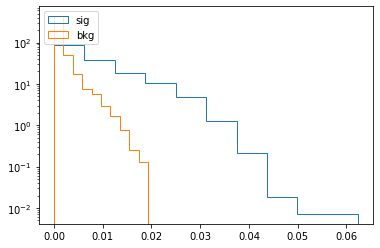

In [15]:
plt.clf()
plt.yscale('log')
#plt.xscale('log')
plt.hist(discrListSig_LLAlt, density=True, color=None, histtype='step', label="sig")
plt.hist(discrListBkg_LLAlt, density=True, color=None, histtype='step', label="bkg")
plt.legend(loc='upper left')
plt.savefig("ll_disc_alt.pdf")
plt.show()

In [16]:
# ROC for alternative linear likelihood estimator

tprLLAlt = []
fprLLAlt = []

maxLL = max(discrListSig_LLAlt) if max(discrListSig_LLAlt)>max(discrListBkg_LLAlt) else max(discrListBkg_LLAlt)
LLdiscrStep = np.arange(0,maxLL,maxLL*1.0/1000.0)
for LLdiscrCut in LLdiscrStep:
    
    tp = (discrListSig_LLAlt>LLdiscrCut).sum()
    fp = (discrListBkg_LLAlt>LLdiscrCut).sum()
    tn = (discrListBkg_LLAlt<LLdiscrCut).sum()
    fn = (discrListSig_LLAlt<LLdiscrCut).sum()
    
    tprLLAlt.append(tp/(tp+fn))
    fprLLAlt.append(fp/(fp+tn))

HtJet  done...
dRLL  done...
dPhiLepMETSelObj  done...
YDelpObj  done...
YUserObj  done...
alphaT  done...
Sphericity  done...
Spherocity  done...
MtLeadLepMET  done...


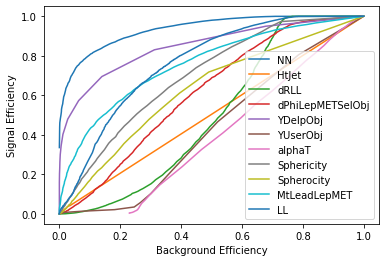

In [200]:
tprNN = []
fprNN = []

sigProb = np.arange(0, 1, 0.01) 
sigPredictSigProb = np.array(sigFullPredict)[:,0]
bkgPredictSigProb = np.array(bkgFullPredict)[:,0]

for x in sigProb: 
     
    tp = (sigPredictSigProb>x).sum() 
    fp = (bkgPredictSigProb>x).sum() 
    fn = (sigPredictSigProb<x).sum() 
    tn = (bkgPredictSigProb<x).sum()

    tprNN.append(tp/(tp+fn))
    fprNN.append(fp/(fp+tn))
    
plt.clf()
plt.plot(fprNN,tprNN, label="NN")

minValList = [0, 0, 0, 0, 0, 0, 0, 0, 0]
maxValList = [200, 5, 3.14, 100, 100, 2, 0.75, 0.8, 400]
stepValList = [1, 0.01, 0.01, 1, 1, 0.01, 0.01, 0.01, 1]


for i in range(len(brNameList)):
    
    tpr = []
    fpr = []
    
    for varDisc in np.arange(minValList[i], maxValList[i], stepValList[i]):
    
        tp = (np.transpose(sigFull)[i]>varDisc).sum()
        fp = (np.transpose(bkgFull)[i]>varDisc).sum()
        tn = (np.transpose(bkgFull)[i]<varDisc).sum()
        fn = (np.transpose(sigFull)[i]<varDisc).sum()
    
        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))

    plt.plot(fpr,tpr, label=brNameList[i].format(i=i))
    print(brNameList[i]," done...")
    
plt.plot(fprLL,tprLL, label="LL")
#plt.plot(fprLLAlt,tprLLAlt, label="LL_Alternative")
plt.legend(loc='best')
plt.ylabel("Signal Efficiency")
plt.xlabel("Background Efficiency")
plt.savefig("ROC_Compared.pdf")
#plt.xscale('log')
#plt.savefig("ROC_Compared_Log.pdf")


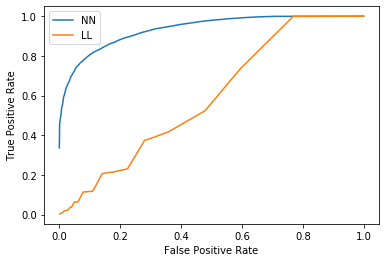

In [120]:
plt.clf()
plt.plot(fprNN,tprNN, label="NN")
plt.plot(fprLL,tprLL, label="LL")
#plt.plot(fprLLAlt,tprLLAlt, label="LL_Alternative")
plt.legend(loc='best')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("roc_nn_ll.pdf")
plt.show()

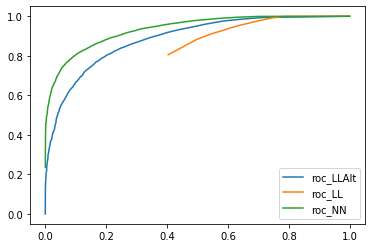

In [54]:
plt.clf()
dR.from_histo(discrListSig_LLAlt, discrListBkg_LLAlt, name="LLAlt")
dR.from_histo(discrListSig, discrListBkg, name="LL")
dR.from_histo(sigPredictSigProb, bkgPredictSigProb, name="NN")
plt.legend()
plt.show()
plt.saveFig("ROC_FromFunction.pdf")